### Import dependencies :

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load data :

### selecting simulation for lambda in [0.4,0.7] :

In [11]:
batch2=pd.read_csv('/home/fayari/Stage/data_augmentation/batch_2.csv')
batch3=pd.read_csv('/home/fayari/Stage/data_augmentation/batch_3.csv')

In [12]:
batch2

,Tg_scat,Tg_abs,AOD,SSA,g1,Z,Zenith_Angle,reflectance,BOA_RT
0,0.939603,0.958361,0.282894,0.946216,0.909348,179,79,0.700068,606.801054
1,0.940200,0.959163,0.282098,0.946064,0.910085,179,79,0.755827,613.066677
2,0.940700,0.959584,0.281302,0.945912,0.910822,179,79,0.184661,587.431127
3,0.941200,0.959991,0.280508,0.945759,0.911559,179,79,0.721911,615.663102
4,0.941700,0.960258,0.279714,0.945968,0.912297,179,79,0.788335,620.979161
...,...,...,...,...,...,...,...,...,...
300495,0.971500,0.990284,0.219899,0.930808,0.950100,1721,17,0.204588,979.228173
300496,0.971700,0.979409,0.219276,0.930612,0.950065,1721,17,0.698400,987.885472
300497,0.971900,0.994898,0.218778,0.930454,0.950031,1721,17,0.676414,995.565616
300498,0.972100,0.995901,0.218156,0.929790,0.949997,1721,17,0.746254,998.074877


In [ ]:
start = 0     # début de la première tranche
length = 15    # taille de chaque tranche (ex: 100 - 40 = 60)
step = 100      # combien on avance à chaque itération

# Optionnel : longueur totale
n = len(batch0)

# Liste pour stocker les sous-DataFrames
slices = []

while start < n:
    end = start + length
    slice_df = batch0[start:end]
    slices.append(slice_df)
    start += step

In [4]:
df = pd.concat([batch2,batch3] ,ignore_index=True)
df

,Tg_scat,Tg_abs,AOD,SSA,g1,Z,Zenith_Angle,reflectance,BOA_RT
0,0.939603,0.958361,0.282894,0.946216,0.909348,179,79,0.700068,606.801054
1,0.940200,0.959163,0.282098,0.946064,0.910085,179,79,0.755827,613.066677
2,0.940700,0.959584,0.281302,0.945912,0.910822,179,79,0.184661,587.431127
3,0.941200,0.959991,0.280508,0.945759,0.911559,179,79,0.721911,615.663102
4,0.941700,0.960258,0.279714,0.945968,0.912297,179,79,0.788335,620.979161
...,...,...,...,...,...,...,...,...,...
600995,0.987500,0.708380,0.162637,0.898951,0.945752,984,67,0.204588,533.931084
600996,0.987600,0.773176,0.162048,0.898584,0.945701,984,67,0.698400,621.413235
600997,0.987700,0.932952,0.161578,0.898289,0.945649,984,67,0.676414,855.373211
600998,0.987800,0.821022,0.161001,0.897924,0.945597,984,67,0.746254,688.408159


In [7]:
def muprime(z,h,µ):
    RAYON_TERRESTRE=6371
    eta = (RAYON_TERRESTRE*1000 + z) / h
    root = (eta*µ)**2  + 2 * eta + 1
    sum = (root)**0.5 - eta * µ
    if sum > 0 :
        return 1/sum
    return 1 

In [6]:
def prepare_df(data):
    data['mu_g']=(6371*1000+data['Z'])/9000
    data['mu_a']=(6371*1000+data['Z'])/2000
    data['AODS']=data['AOD']*data['SSA']
    data['Cos(SZA)']=np.cos(np.radians(data['Zenith_Angle']))
    data['Ta_abs']=np.exp(-data['AOD']*(1-data['SSA']))
    data['muprime_g'] = data.apply(lambda row: muprime(row['Z'],9000,row['Cos(SZA)']), axis=1)
    data['muprime_a'] = data.apply(lambda row: muprime(row['Z'],2000,row['Cos(SZA)']), axis=1)
    data['mprime_g']=np.exp(-data['Z']/9000)/data['muprime_g']
    data['mprime_a']=np.exp(-data['Z']/2000)/data['muprime_a']
    data['GOD']=-np.log(data['Tg_scat'])
    data['alpha'] = data.apply(lambda row: calculate_alpha(row['Tg_abs'],row['Ta_abs'],row['GOD'],row['AODS'],row['mprime_g'],row['mprime_a'],row['BOA_RT']), axis=1)
    data.rename(columns={'reflectance': 'R_scence'}, inplace=True)
    data.rename(columns={'Zenith_Angle': 'SZA'}, inplace=True)
    ordered_columns = [
        'Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
        'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
        'mprime_g', 'mprime_a', 'BOA_RT', 'alpha'
    ]
    data = data[ordered_columns]
    return data

In [8]:
df=prepare_df(df)
df

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scence,g1,Cos(SZA),mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,alpha
0,0.939603,0.958361,0.9849,0.946216,0.062298,0.282894,0.267678,79,179,0.700068,0.909348,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,606.801054,0.319673
1,0.940200,0.959163,0.9849,0.946064,0.061663,0.282098,0.266883,79,179,0.755827,0.910085,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,613.066677,0.311476
2,0.940700,0.959584,0.9849,0.945912,0.061131,0.281302,0.266087,79,179,0.184661,0.910822,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,587.431127,0.390347
3,0.941200,0.959991,0.9849,0.945759,0.060600,0.280508,0.265293,79,179,0.721911,0.911559,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,615.663102,0.315068
4,0.941700,0.960258,0.9850,0.945968,0.060069,0.279714,0.264600,79,179,0.788335,0.912297,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,620.979161,0.305357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600995,0.987500,0.708380,0.9837,0.898951,0.012579,0.162637,0.146202,67,984,0.204588,0.945752,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,533.931084,-1.618412
600996,0.987600,0.773176,0.9837,0.898584,0.012478,0.162048,0.145614,67,984,0.698400,0.945701,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,621.413235,-1.233303
600997,0.987700,0.932952,0.9837,0.898289,0.012376,0.161578,0.145144,67,984,0.676414,0.945649,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,855.373211,-0.266460
600998,0.987800,0.821022,0.9837,0.897924,0.012275,0.161001,0.144566,67,984,0.746254,0.945597,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,688.408159,-0.946639


In [9]:
df.rename(columns={'R_scence': 'R_scene'}, inplace=True)

In [10]:
df

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,g1,Cos(SZA),mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,alpha
0,0.939603,0.958361,0.9849,0.946216,0.062298,0.282894,0.267678,79,179,0.700068,0.909348,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,606.801054,0.319673
1,0.940200,0.959163,0.9849,0.946064,0.061663,0.282098,0.266883,79,179,0.755827,0.910085,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,613.066677,0.311476
2,0.940700,0.959584,0.9849,0.945912,0.061131,0.281302,0.266087,79,179,0.184661,0.910822,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,587.431127,0.390347
3,0.941200,0.959991,0.9849,0.945759,0.060600,0.280508,0.265293,79,179,0.721911,0.911559,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,615.663102,0.315068
4,0.941700,0.960258,0.9850,0.945968,0.060069,0.279714,0.264600,79,179,0.788335,0.912297,0.190809,707.908778,3185.5895,0.194307,0.191598,5.045154,4.772428,620.979161,0.305357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600995,0.987500,0.708380,0.9837,0.898951,0.012579,0.162637,0.146202,67,984,0.204588,0.945752,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,533.931084,-1.618412
600996,0.987600,0.773176,0.9837,0.898584,0.012478,0.162048,0.145614,67,984,0.698400,0.945701,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,621.413235,-1.233303
600997,0.987700,0.932952,0.9837,0.898289,0.012376,0.161578,0.145144,67,984,0.676414,0.945649,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,855.373211,-0.266460
600998,0.987800,0.821022,0.9837,0.897924,0.012275,0.161001,0.144566,67,984,0.746254,0.945597,0.390731,707.998222,3185.9920,0.392255,0.391071,2.285331,1.563405,688.408159,-0.946639


##### I noticed that for the most values of alpha in range [0.4;0.6] are higher than 0.3 so we will duplicate only those values.

In [117]:
to_duplicate=df[df['alpha']>0.25]

In [118]:
to_duplicate['BOA_RT']=to_duplicate['BOA_RT'].astype(float)

/tmp/ipykernel_1294176/2616379595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_duplicate['BOA_RT']=to_duplicate['BOA_RT'].astype(float)


In [119]:
y=to_duplicate['alpha']
X=to_duplicate.drop(columns=['alpha','BOA_RT'])
z=to_duplicate['BOA_RT']

n_copies = 4
X_augmented = []
y_augmented = []
z_augmented = []

for _ in range(n_copies):
    noise = np.random.normal(loc=0.0, scale=0.01, size=X.shape)  # petit bruit
    X_aug = X.values + noise
    X_augmented.append(X)
    y_augmented.append(y.values)
    z_augmented.append(z.values)
    

# Concaténer
X_augmented = pd.DataFrame(np.vstack(X_augmented), columns=X.columns)
y_augmented = pd.Series(np.hstack(y_augmented))
z_augmented = pd.Series(np.hstack(z_augmented))

X = pd.concat([X, X_augmented], ignore_index=True)
y = pd.concat([y, y_augmented], ignore_index=True)
z = pd.concat([z, z_augmented], ignore_index=True)

In [120]:
X['alpha']=y.values
X['BOA_RT']=z.values
X

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,g1,Cos(SZA),mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,alpha,BOA_RT
0,0.697400,0.996201,0.9793,0.952949,0.360396,0.444570,0.423653,71.0,1524.0,0.442505,0.899439,0.325568,708.058222,3186.2620,0.327493,0.325998,2.577848,1.431701,0.331866,698.712768
1,0.700961,0.996761,0.9794,0.953021,0.355303,0.443071,0.422256,71.0,1524.0,0.701424,0.899216,0.325568,708.058222,3186.2620,0.327493,0.325998,2.577848,1.431701,0.256592,748.067501
2,0.704400,0.997200,0.9794,0.952865,0.350409,0.441611,0.420795,71.0,1524.0,0.459676,0.898993,0.325568,708.058222,3186.2620,0.327493,0.325998,2.577848,1.431701,0.327015,708.011718
3,0.707800,0.996800,0.9795,0.952948,0.345594,0.440212,0.419499,71.0,1524.0,0.673773,0.898770,0.325568,708.058222,3186.2620,0.327493,0.325998,2.577848,1.431701,0.265128,746.769846
4,0.714454,0.997400,0.9796,0.952864,0.336237,0.437265,0.416654,71.0,1524.0,0.182240,0.898324,0.325568,708.058222,3186.2620,0.327493,0.325998,2.577848,1.431701,0.407895,672.236843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163655,0.941700,0.960258,0.9850,0.945968,0.060069,0.279714,0.264600,17.0,1721.0,0.052386,0.912297,0.956305,708.080111,3186.3605,0.956368,0.956319,0.863631,0.442269,0.357021,929.005949
1163656,0.946400,0.959131,0.9852,0.945233,0.055090,0.272256,0.257346,17.0,1721.0,0.106808,0.919668,0.956305,708.080111,3186.3605,0.956368,0.956319,0.863631,0.442269,0.300583,934.249274
1163657,0.949500,0.970149,0.9853,0.944582,0.051820,0.267226,0.252417,17.0,1721.0,0.086821,0.924828,0.956305,708.080111,3186.3605,0.956368,0.956319,0.863631,0.442269,0.292819,945.123478
1163658,0.954588,0.977831,0.9856,0.943839,0.046475,0.258268,0.243763,17.0,1721.0,0.098001,0.934410,0.956305,708.080111,3186.3605,0.956368,0.956319,0.863631,0.442269,0.258455,955.760963


In [121]:
X.to_csv('noisy_duplicated_data.csv',index=False)

In [106]:
import pandas as pd
df_no_outliers=pd.read_csv('no_outliers_2.csv')
df_no_outliers

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,g1,Cos(SZA),mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,alpha
0,0.296167,0.036885,0.9667,0.940937,1.216833,0.573410,0.539543,71,1524,0.700068,0.916053,0.325568,708.058222,3186.262,0.327493,0.325998,2.577848,1.431701,0.125221,0.158370
1,0.309415,0.096529,0.9675,0.942022,1.173071,0.569868,0.536828,71,1524,0.755827,0.915627,0.325568,708.058222,3186.262,0.327493,0.325998,2.577848,1.431701,0.945519,0.437282
2,0.322689,0.205904,0.9683,0.943120,1.131066,0.566338,0.534125,71,1524,0.184661,0.915201,0.325568,708.058222,3186.262,0.327493,0.325998,2.577848,1.431701,4.978566,0.713700
3,0.335800,0.336993,0.9691,0.944232,1.091240,0.562821,0.531433,71,1524,0.721911,0.914775,0.325568,708.058222,3186.262,0.327493,0.325998,2.577848,1.431701,23.378361,0.481675
4,0.348900,0.448544,0.9698,0.945190,1.052970,0.559491,0.528825,71,1524,0.788335,0.914349,0.325568,708.058222,3186.262,0.327493,0.325998,2.577848,1.431701,54.669118,0.409920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384667,0.996800,0.960628,0.9850,0.841514,0.003205,0.095363,0.080249,32,134,0.204588,0.936086,0.848048,707.903778,3185.567,0.848282,0.848100,1.161432,1.102694,937.545168,0.035316
1384668,0.996800,0.965511,0.9850,0.840490,0.003205,0.094750,0.079637,32,134,0.698400,0.935950,0.848048,707.903778,3185.567,0.848282,0.848100,1.161432,1.102694,948.623464,-0.141689
1384669,0.996900,0.989428,0.9850,0.839372,0.003105,0.094091,0.078977,32,134,0.676414,0.935815,0.848048,707.903778,3185.567,0.848282,0.848100,1.161432,1.102694,975.688630,-0.134475
1384670,0.996900,0.958618,0.9851,0.839514,0.003105,0.093542,0.078530,32,134,0.746254,0.935679,0.848048,707.903778,3185.567,0.848282,0.848100,1.161432,1.102694,941.541184,-0.165893


(-2.0, 1.0)

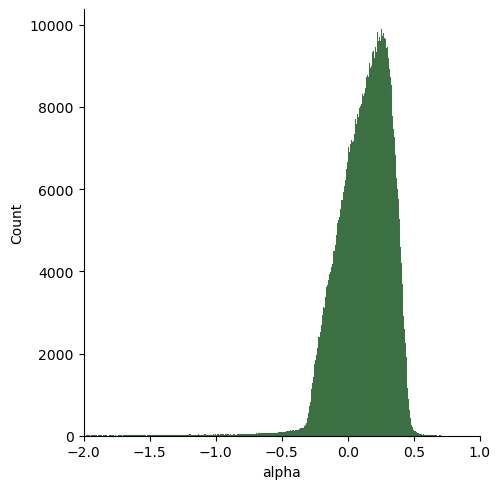

In [109]:
import seaborn as sns
sns.displot(df['alpha'], color = '#01490a')
plt.xlim(-2, 1)

#### as we can see here alpha valuers are in range [-0.55;0.7] with a pic in 0.3

## Alpha with other features :

In [ ]:
sns.pairplot(df_no_outliers)

## SZA :

In [ ]:
sns.pairplot(df_no_outliers)

<Axes: xlabel='SZA', ylabel='alpha'>

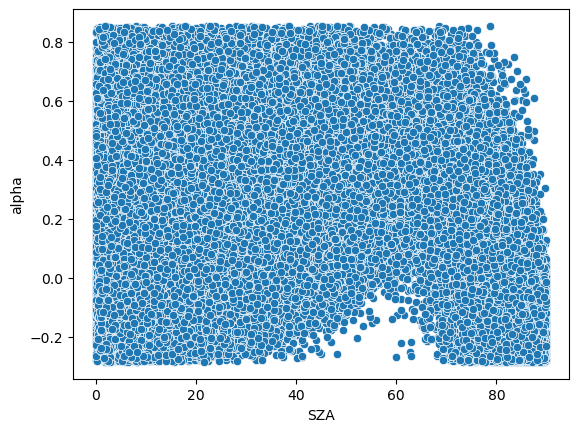

In [ ]:
sns.scatterplot(x=df_no_outliers['SZA'], y=df_no_outliers['alpha'])

In [79]:
df_no_outliers.columns

Index(['Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
       'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
       'mprime_g', 'mprime_a', 'BOA_RT', 'alpha'],
      dtype='object')

/home/fayari/miniforge3/envs/myptd/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


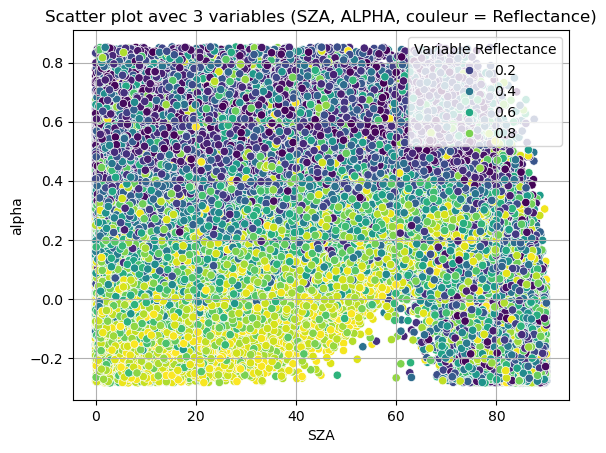

In [ ]:
sns.scatterplot(data=df_no_outliers,x='SZA', y='alpha', hue='R_scence', palette='viridis', sizes=(20, 200))
plt.title('Scatter plot avec 3 variables (SZA, ALPHA, couleur = Reflectance)')
plt.legend(title='Variable Reflectance')
plt.grid(True)
plt.show()

### For high reflectance values and low SZA values we have low values of alpha

/home/fayari/miniforge3/envs/myptd/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


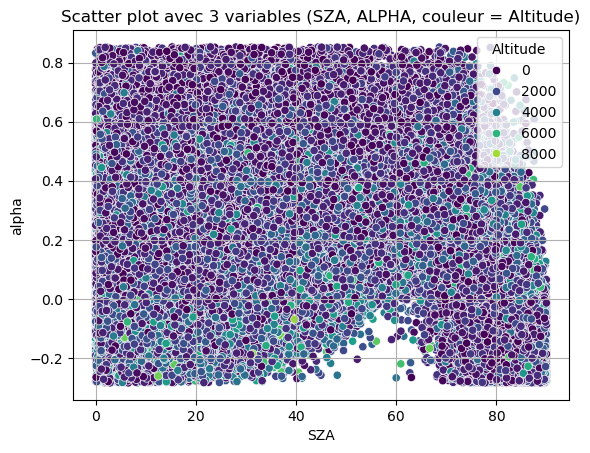

In [ ]:
sns.scatterplot(data=df_no_outliers,x='SZA', y='alpha', hue='Z', palette='viridis', sizes=(20, 200))
plt.title('Scatter plot avec 3 variables (SZA, ALPHA, couleur = Altitude)')
plt.legend(title='Altitude')
plt.grid(True)
plt.show()

In [38]:
df_no_outliers.columns

Index(['Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
       'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
       'mprime_g', 'mprime_a', 'BOA_RT', 'alpha'],
      dtype='object')

### Tg_scat :

<Axes: xlabel='Tg_scat', ylabel='alpha'>

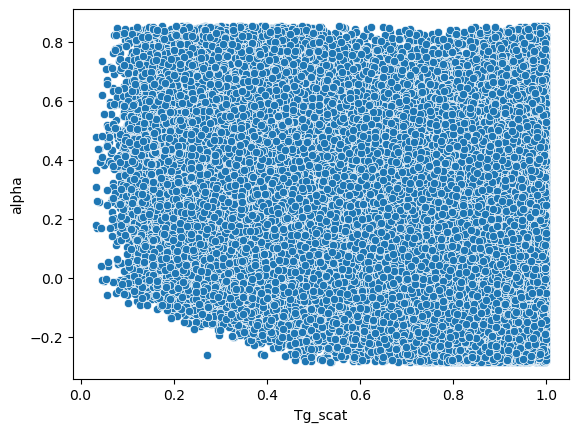

In [39]:
sns.scatterplot(data=df_no_outliers,x='Tg_scat', y='alpha')

/home/fayari/miniforge3/envs/myptd/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


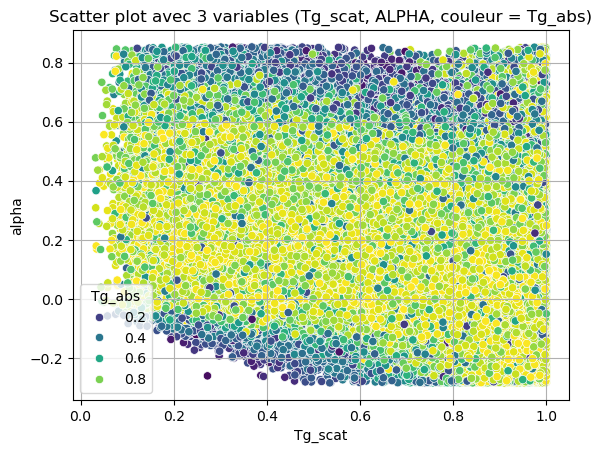

In [41]:
sns.scatterplot(data=df_no_outliers,x='Tg_scat', y='alpha', hue='Tg_abs', palette='viridis', sizes=(20, 200))
plt.title('Scatter plot avec 3 variables (Tg_scat, ALPHA, couleur = Tg_abs)')
plt.legend(title='Tg_abs')
plt.grid(True)
plt.show()

In [42]:
df.columns

Index(['Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
       'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
       'mprime_g', 'mprime_a', 'BOA_RT', 'alpha'],
      dtype='object')

<Axes: xlabel='SSA', ylabel='alpha'>

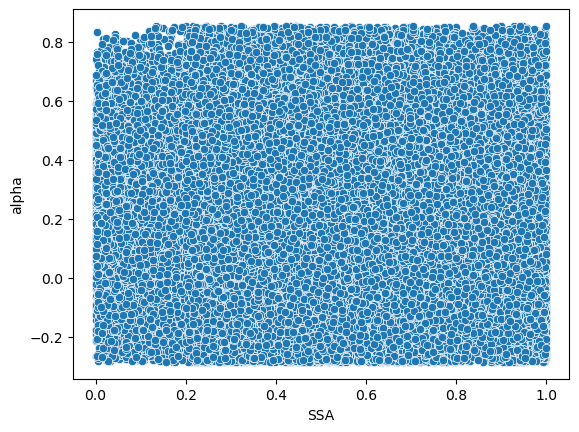

In [43]:
sns.scatterplot(data=df_no_outliers,x='SSA', y='alpha')

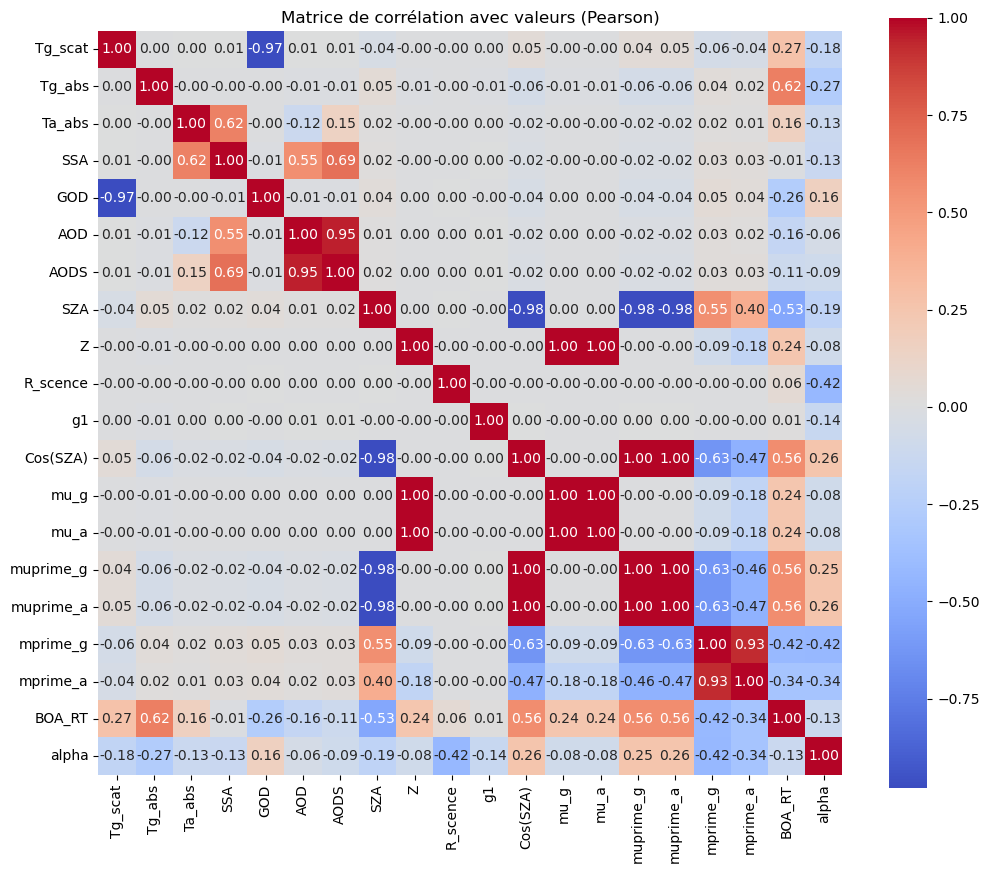

In [47]:
corr_matrix = df_no_outliers.corr(method='pearson')  # ou 'spearman'

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,       # ✅ Affiche les valeurs dans chaque case
            fmt=".2f",         # Formate les nombres (2 décimales)
            cmap='coolwarm', 
            square=True, 
            cbar=True)

plt.title("Matrice de corrélation avec valeurs (Pearson)")
plt.show()

### We have no linearity between alpha and other parameters (correlation values are low)

In [80]:
df_no_outliers.columns

Index(['Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
       'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
       'mprime_g', 'mprime_a', 'BOA_RT', 'alpha'],
      dtype='object')

### Reflectance :

<Axes: xlabel='R_scence', ylabel='alpha'>

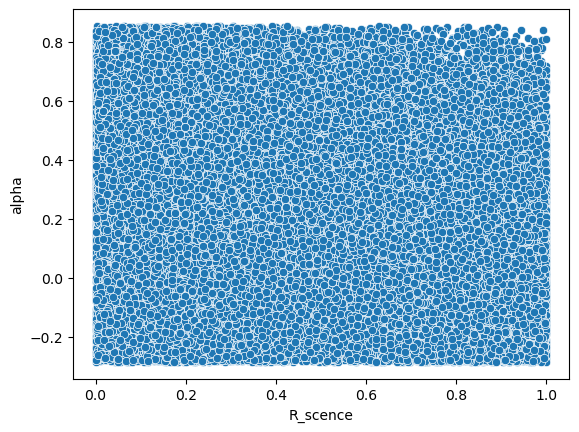

In [49]:
sns.scatterplot(data=df_no_outliers,x='R_scence', y='alpha')

### Single scattering albedo :

<Axes: xlabel='SSA', ylabel='alpha'>

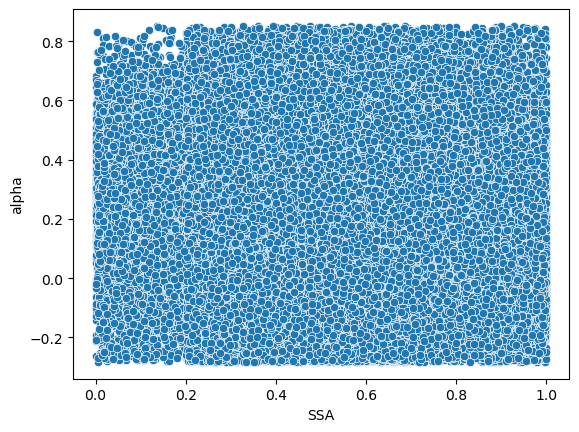

In [111]:
sns.scatterplot(x=df_no_outliers['SSA'], y=df_no_outliers['alpha'])

### Tg scat :

<Axes: xlabel='Tg_scat', ylabel='alpha'>

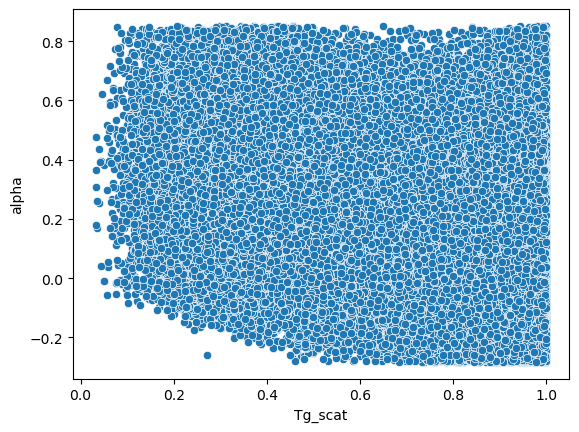

In [112]:
sns.scatterplot(x=df_no_outliers['Tg_scat'], y=df_no_outliers['alpha'])

### Feature engineering :

#### Adding some significant features :

In [31]:
# Step 1: Compute and apply binning
bins_g = pd.cut(df_no_outliers['mprime_g'], bins=5, retbins=True)[1]
bins_a = pd.cut(df_no_outliers['mprime_a'], bins=5, retbins=True)[1]
df_no_outliers['mprime_g_bin'] = pd.cut(df_no_outliers['mprime_g'], bins=bins_g, labels=False, include_lowest=True)
df_no_outliers['mprime_a_bin'] = pd.cut(df_no_outliers['mprime_a'], bins=bins_a, labels=False, include_lowest=True)
np.save('mprime_g_bins.npy', bins_g)
np.save('mprime_a_bins.npy', bins_a)

/tmp/ipykernel_59701/1099574277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['mprime_g_bin'] = pd.cut(df_no_outliers['mprime_g'], bins=bins_g, labels=False, include_lowest=True)
/tmp/ipykernel_59701/1099574277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['mprime_a_bin'] = pd.cut(df_no_outliers['mprime_a'], bins=bins_a, labels=False, include_lowest=True)


<Axes: xlabel='mprime_a_bin', ylabel='alpha'>

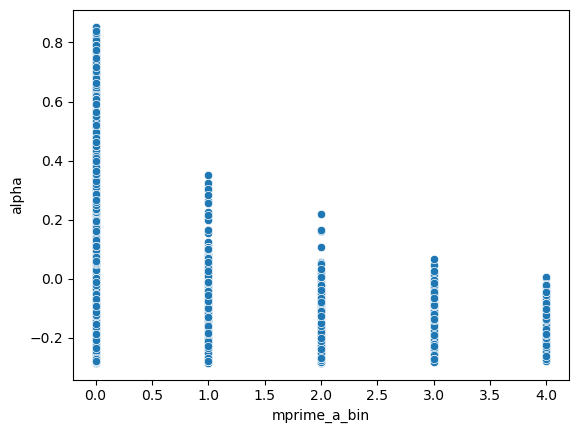

In [32]:
sns.scatterplot(data=df_no_outliers,x='mprime_a_bin',y='alpha')

<Axes: xlabel='mprime_g_bin', ylabel='alpha'>

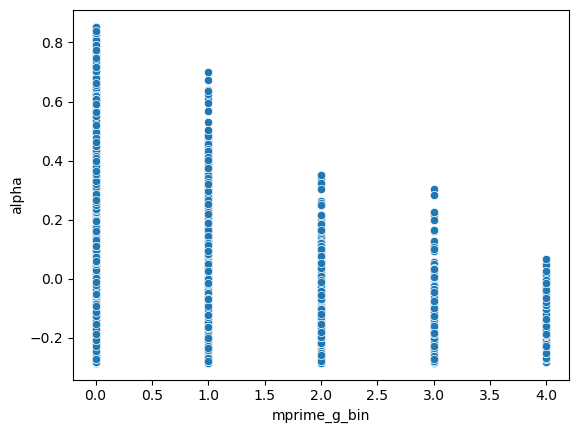

In [33]:
sns.scatterplot(data=df_no_outliers,x='mprime_g_bin',y='alpha')

In [34]:
df_no_outliers['mprime_g']

0         5.695816
1         2.122562
2         0.929959
3         1.382759
4         0.990440
            ...   
377995    1.064013
377996    1.690357
377997    0.959983
377998    0.807461
377999    1.030396
Name: mprime_g, Length: 362503, dtype: float64

### Data preprocessing :

In [35]:
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,OneHotEncoder
from warnings import filterwarnings
filterwarnings("ignore")

In [36]:
df_no_outliers

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scence,...,mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,alpha,mprime_g_bin,mprime_a_bin
0,0.984234,0.967931,0.849827,0.595673,0.015892,0.402452,0.239730,81.357114,1137.064781,0.370253,...,708.015229,3186.068532,0.154730,0.151289,5.695816,3.743539,429.332315,0.133511,0,0
1,0.808703,0.502863,0.971936,0.754977,0.212324,0.116173,0.087708,69.669734,2695.217813,0.364243,...,708.188358,3186.847609,0.349206,0.347828,2.122562,0.747097,194.210750,0.363279,0,0
2,0.266592,0.973465,0.845395,0.580608,1.322036,0.400463,0.232512,17.550390,1081.897319,0.672173,...,708.009100,3186.040949,0.953519,0.953467,0.929959,0.610609,648.404343,0.280041,0,0
3,0.830782,0.963485,0.971736,0.270474,0.185388,0.039302,0.010630,44.256621,81.149965,0.775990,...,707.897906,3185.540575,0.716701,0.716328,1.382759,1.340499,885.138727,0.125099,0,0
4,0.600291,0.839312,0.797427,0.652968,0.510340,0.652287,0.425923,24.480144,932.892398,0.777209,...,707.992544,3185.966446,0.910238,0.910135,0.990440,0.689159,602.697524,0.320636,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377995,0.765135,0.641704,0.963197,0.825442,0.267702,0.214810,0.177313,22.962506,183.428535,0.740243,...,707.909270,3185.591714,0.920877,0.920786,1.064013,0.990855,534.140819,0.364438,0,0
377996,0.749872,0.800834,0.842750,0.719020,0.287853,0.608888,0.437803,55.826486,452.874619,0.016449,...,707.939208,3185.726437,0.562559,0.561892,1.690357,1.419079,387.264753,0.564494,0,0
377997,0.538644,0.788402,0.827843,0.727779,0.618701,0.694040,0.505108,6.365350,423.130196,0.050525,...,707.935903,3185.711565,0.993844,0.993837,0.959983,0.814335,476.450471,0.591383,0,0
377998,0.634018,0.991370,0.965507,0.661306,0.455678,0.103640,0.068538,7.738936,2006.981168,0.832208,...,708.111887,3186.503491,0.990905,0.990895,0.807461,0.369966,1015.811664,-0.093105,0,0


In [37]:
df_no_outliers.columns

Index(['Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
       'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
       'mprime_g', 'mprime_a', 'BOA_RT', 'alpha', 'mprime_g_bin',
       'mprime_a_bin'],
      dtype='object')

In [38]:
df_no_outliers.reset_index(drop=True,inplace=True)
df_no_outliers

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scence,...,mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,alpha,mprime_g_bin,mprime_a_bin
0,0.984234,0.967931,0.849827,0.595673,0.015892,0.402452,0.239730,81.357114,1137.064781,0.370253,...,708.015229,3186.068532,0.154730,0.151289,5.695816,3.743539,429.332315,0.133511,0,0
1,0.808703,0.502863,0.971936,0.754977,0.212324,0.116173,0.087708,69.669734,2695.217813,0.364243,...,708.188358,3186.847609,0.349206,0.347828,2.122562,0.747097,194.210750,0.363279,0,0
2,0.266592,0.973465,0.845395,0.580608,1.322036,0.400463,0.232512,17.550390,1081.897319,0.672173,...,708.009100,3186.040949,0.953519,0.953467,0.929959,0.610609,648.404343,0.280041,0,0
3,0.830782,0.963485,0.971736,0.270474,0.185388,0.039302,0.010630,44.256621,81.149965,0.775990,...,707.897906,3185.540575,0.716701,0.716328,1.382759,1.340499,885.138727,0.125099,0,0
4,0.600291,0.839312,0.797427,0.652968,0.510340,0.652287,0.425923,24.480144,932.892398,0.777209,...,707.992544,3185.966446,0.910238,0.910135,0.990440,0.689159,602.697524,0.320636,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362498,0.765135,0.641704,0.963197,0.825442,0.267702,0.214810,0.177313,22.962506,183.428535,0.740243,...,707.909270,3185.591714,0.920877,0.920786,1.064013,0.990855,534.140819,0.364438,0,0
362499,0.749872,0.800834,0.842750,0.719020,0.287853,0.608888,0.437803,55.826486,452.874619,0.016449,...,707.939208,3185.726437,0.562559,0.561892,1.690357,1.419079,387.264753,0.564494,0,0
362500,0.538644,0.788402,0.827843,0.727779,0.618701,0.694040,0.505108,6.365350,423.130196,0.050525,...,707.935903,3185.711565,0.993844,0.993837,0.959983,0.814335,476.450471,0.591383,0,0
362501,0.634018,0.991370,0.965507,0.661306,0.455678,0.103640,0.068538,7.738936,2006.981168,0.832208,...,708.111887,3186.503491,0.990905,0.990895,0.807461,0.369966,1015.811664,-0.093105,0,0


### Standard Scaler :

In [39]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder
cols_to_scale = df_no_outliers.drop(columns=['alpha','BOA_RT','mprime_a_bin','mprime_g_bin']).columns
cols_to_encode = ['mprime_a_bin', 'mprime_g_bin']

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_no_outliers[cols_to_scale])

# Encodage one-hot
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_bins_encoded = encoder.fit_transform(df_no_outliers[cols_to_encode])

# Récupération des noms des colonnes encodées
encoded_feature_names = encoder.get_feature_names_out(cols_to_encode)

# Construction du DataFrame final
df_scaled = pd.DataFrame(
    np.concatenate([X_scaled, X_bins_encoded], axis=1),
    columns=list(cols_to_scale) + list(encoded_feature_names),
    index=df_no_outliers.index  # Pour conserver les bons index
)


In [40]:
df_scaled

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scence,...,mprime_a_bin_0,mprime_a_bin_1,mprime_a_bin_2,mprime_a_bin_3,mprime_a_bin_4,mprime_g_bin_0,mprime_g_bin_1,mprime_g_bin_2,mprime_g_bin_3,mprime_g_bin_4
0,0.938938,0.830099,-0.143116,0.205274,-0.748201,-0.102195,-0.148214,1.494961,-0.196407,-0.449844,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.072507,-1.551574,1.189851,0.880461,-0.191308,-0.932700,-0.652588,1.032032,1.082365,-0.470705,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-2.603383,0.858439,-0.191497,0.141423,2.954771,-0.107965,-0.172161,-1.032376,-0.241683,0.598065,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.181490,0.807331,1.187661,-1.173034,-0.267672,-1.155707,-0.908316,0.025438,-1.062994,0.958397,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.956225,0.171426,-0.715124,0.448112,0.653581,0.622586,0.469534,-0.757894,-0.363971,0.962627,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362498,-0.142545,-0.840552,1.094456,1.179116,-0.034307,-0.646551,-0.355299,-0.818006,-0.979054,0.834325,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
362499,-0.217888,-0.025624,-0.220377,0.728064,0.022821,0.496683,0.508949,0.483711,-0.757920,-1.677835,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
362500,-1.260520,-0.089295,-0.383105,0.765189,0.960787,0.743714,0.732254,-1.475407,-0.782331,-1.559563,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
362501,-0.789749,0.950134,1.119665,0.483449,0.498611,-0.969059,-0.716191,-1.421001,0.517531,1.153519,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
df_scaled['BOA_RT']=df_no_outliers['BOA_RT']
df_scaled['alpha']=df_no_outliers['alpha']
df_scaled

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scence,...,mprime_a_bin_2,mprime_a_bin_3,mprime_a_bin_4,mprime_g_bin_0,mprime_g_bin_1,mprime_g_bin_2,mprime_g_bin_3,mprime_g_bin_4,BOA_RT,alpha
0,0.938938,0.830099,-0.143116,0.205274,-0.748201,-0.102195,-0.148214,1.494961,-0.196407,-0.449844,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,429.332315,0.133511
1,0.072507,-1.551574,1.189851,0.880461,-0.191308,-0.932700,-0.652588,1.032032,1.082365,-0.470705,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,194.210750,0.363279
2,-2.603383,0.858439,-0.191497,0.141423,2.954771,-0.107965,-0.172161,-1.032376,-0.241683,0.598065,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,648.404343,0.280041
3,0.181490,0.807331,1.187661,-1.173034,-0.267672,-1.155707,-0.908316,0.025438,-1.062994,0.958397,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,885.138727,0.125099
4,-0.956225,0.171426,-0.715124,0.448112,0.653581,0.622586,0.469534,-0.757894,-0.363971,0.962627,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,602.697524,0.320636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362498,-0.142545,-0.840552,1.094456,1.179116,-0.034307,-0.646551,-0.355299,-0.818006,-0.979054,0.834325,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,534.140819,0.364438
362499,-0.217888,-0.025624,-0.220377,0.728064,0.022821,0.496683,0.508949,0.483711,-0.757920,-1.677835,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,387.264753,0.564494
362500,-1.260520,-0.089295,-0.383105,0.765189,0.960787,0.743714,0.732254,-1.475407,-0.782331,-1.559563,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,476.450471,0.591383
362501,-0.789749,0.950134,1.119665,0.483449,0.498611,-0.969059,-0.716191,-1.421001,0.517531,1.153519,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1015.811664,-0.093105


In [42]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362503 entries, 0 to 362502
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Tg_scat         362503 non-null  float64
 1   Tg_abs          362503 non-null  float64
 2   Ta_abs          362503 non-null  float64
 3   SSA             362503 non-null  float64
 4   GOD             362503 non-null  float64
 5   AOD             362503 non-null  float64
 6   AODS            362503 non-null  float64
 7   SZA             362503 non-null  float64
 8   Z               362503 non-null  float64
 9   R_scence        362503 non-null  float64
 10  g1              362503 non-null  float64
 11  Cos(SZA)        362503 non-null  float64
 12  mu_g            362503 non-null  float64
 13  mu_a            362503 non-null  float64
 14  muprime_g       362503 non-null  float64
 15  muprime_a       362503 non-null  float64
 16  mprime_g        362503 non-null  float64
 17  mprime_a  

In [43]:
import joblib
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [45]:
cols_to_scale_inv = df_scaled.drop(columns=['mprime_a_bin_0', 'mprime_a_bin_1',
       'mprime_a_bin_2', 'mprime_a_bin_3', 'mprime_a_bin_4', 'mprime_g_bin_0',
       'mprime_g_bin_1', 'mprime_g_bin_2', 'mprime_g_bin_3', 'mprime_g_bin_4','BOA_RT','alpha'
       ]).columns
cols_to_encode_inv = ['mprime_a_bin_0', 'mprime_a_bin_1',
       'mprime_a_bin_2', 'mprime_a_bin_3', 'mprime_a_bin_4', 'mprime_g_bin_0',
       'mprime_g_bin_1', 'mprime_g_bin_2', 'mprime_g_bin_3', 'mprime_g_bin_4',
       ]

In [46]:
import joblib
scaler=joblib.load('scaler.pkl')
encoder=joblib.load('encoder.pkl')
X_scaled_part = df_scaled[cols_to_scale_inv].values
X_encoded_part = df_scaled[cols_to_encode_inv].values
# 2. Inverser la standardisation
X_original_scaled = scaler.inverse_transform(X_scaled_part)

# 3. Inverser l'encodage
X_original_categoricals = encoder.inverse_transform(X_encoded_part)

In [47]:
df_reconstructed = pd.DataFrame(
    X_original_scaled,
    columns=['Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
       'R_scence', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
       'mprime_g', 'mprime_a'],
    index=df_scaled.index
)
df_categoricals = pd.DataFrame(
    X_original_categoricals,
    columns=['mprime_a_bin', 'mprime_g_bin'],
    index=df_scaled.index
)
df_real = pd.concat([df_reconstructed, df_categoricals], axis=1)

In [48]:
df_real

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scence,g1,Cos(SZA),mu_g,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,mprime_a_bin,mprime_g_bin
0,0.984234,0.967931,0.849827,0.595673,0.015892,0.402452,0.239730,81.357114,1137.064781,0.370253,0.946187,0.150275,708.015229,3186.068532,0.154730,0.151289,5.695816,3.743539,0,0
1,0.808703,0.502863,0.971936,0.754977,0.212324,0.116173,0.087708,69.669734,2695.217813,0.364243,0.910936,0.347431,708.188358,3186.847609,0.349206,0.347828,2.122562,0.747097,0,0
2,0.266592,0.973465,0.845395,0.580608,1.322036,0.400463,0.232512,17.550390,1081.897319,0.672173,0.896924,0.953452,708.009100,3186.040949,0.953519,0.953467,0.929959,0.610609,0,0
3,0.830782,0.963485,0.971736,0.270474,0.185388,0.039302,0.010630,44.256621,81.149965,0.775990,0.869940,0.716221,707.897906,3185.540575,0.716701,0.716328,1.382759,1.340499,0,0
4,0.600291,0.839312,0.797427,0.652968,0.510340,0.652287,0.425923,24.480144,932.892398,0.777209,0.878946,0.910105,707.992544,3185.966446,0.910238,0.910135,0.990440,0.689159,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362498,0.765135,0.641704,0.963197,0.825442,0.267702,0.214810,0.177313,22.962506,183.428535,0.740243,0.668902,0.920760,707.909270,3185.591714,0.920877,0.920786,1.064013,0.990855,0,0
362499,0.749872,0.800834,0.842750,0.719020,0.287853,0.608888,0.437803,55.826486,452.874619,0.016449,0.818049,0.561701,707.939208,3185.726437,0.562559,0.561892,1.690357,1.419079,0,0
362500,0.538644,0.788402,0.827843,0.727779,0.618701,0.694040,0.505108,6.365350,423.130196,0.050525,0.896188,0.993835,707.935903,3185.711565,0.993844,0.993837,0.959983,0.814335,0,0
362501,0.634018,0.991370,0.965507,0.661306,0.455678,0.103640,0.068538,7.738936,2006.981168,0.832208,0.860886,0.990892,708.111887,3186.503491,0.990905,0.990895,0.807461,0.369966,0,0


In [49]:
np.exp(-df_real['AOD']*(1-df_real['SSA']))

0         0.849827
1         0.971936
2         0.845395
3         0.971736
4         0.797427
            ...   
362498    0.963197
362499    0.842750
362500    0.827843
362501    0.965507
362502    0.665318
Length: 362503, dtype: float64

In [50]:
df_real['Ta_abs']

0         0.849827
1         0.971936
2         0.845395
3         0.971736
4         0.797427
            ...   
362498    0.963197
362499    0.842750
362500    0.827843
362501    0.965507
362502    0.665318
Name: Ta_abs, Length: 362503, dtype: float64

In [54]:
df['Ta_abs']

0         0.849827
1         0.971936
2         0.845395
3         0.971736
4         0.797427
            ...   
377995    0.963197
377996    0.842750
377997    0.827843
377998    0.965507
377999    0.665318
Name: Ta_abs, Length: 377999, dtype: float64

In [53]:
df_scaled.to_csv('preprocessed_data_.csv',index=False)

### RobustScaler :

In [ ]:
cols_to_scale = df_no_outliers.drop(columns=['alpha','mprime_a_bin','mprime_g_bin']).columns
cols_to_encode = ['mprime_a_bin', 'mprime_g_bin']
# Standardisation
Robust= RobustScaler()
X_scaled = Robust.fit_transform(df_no_outliers[cols_to_scale])

# Encodage one-hot
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_bins_encoded = encoder.fit_transform(df_no_outliers[cols_to_encode])

# Récupération des noms des colonnes encodées
encoded_feature_names = encoder.get_feature_names_out(cols_to_encode)

# Construction du DataFrame final
df_scaled = pd.DataFrame(
    np.concatenate([X_scaled, X_bins_encoded], axis=1),
    columns=list(cols_to_scale) + list(encoded_feature_names),
    index=df_no_outliers.index  # Pour conserver les bons index
)